**Univerisity of Pisa - M.Sc. Computer Science, Artificial Intelligence**  
**Intelligent system for pattern recognition - a.a. 2021/22**

**Author:** Irene Pisani - i.pisani1@studenti.unipi.it - matricola 560104  
**Date:** 16 May 2022

### **3° MIDTERM: assignment n°6**
# **TEXT PROCESSING: FAKE NEWS DETECTION WITH BI-DIRECTIONAL LSTM RNN**

***Abstract.*** 
The dataset contains real and fake news, including their title, text, subject, and date. The objective is to train a binary classifier to recognize fake news. You are free to choose the model's architecture, but you should describe and justify your design choices. 

Notice that the fake and real news in the dataset are balanced. However, in the real world, real news are much more frequent than fake ones (hopefully). Simulate the effect of the data imbalance by undersampling/oversampling one of the classes in the training set and compute the test accuracy on a (balanced) test set. Then, try to use a mechanism to make the training robust to imbalances, such as weighting the loss for the samples depending on their class. Discuss the results of this mitigation.

NOTE ON PREPROCESSING: you are allowed to preprocess the data however you want (e.g. using pretrained embeddings, dropping some features, just a bag-of-words), but the classification model must be trained by yourself.



---

## **1. Preliminary steps: required tools and dataset**

Python version 3.7 was used for this project.  For the code below to work properly, it is necessary to install some auxiliary libraries (as NLTK, Keras, SciKit Learn and others) and tools (as pretrained Glove embeddings).

In [ ]:
import pandas as pd 
import numpy  as np
import re 
import os

import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot')

# KERAS -> useful to create a model 
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# SKLEARN -> useful for model selection and model assestment
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import class_weight

# NLTK -> useful to pre-process dataset
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# IMBALANCE LEARN library -> useful to create imbalance training set 
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# GLOVE -> pretrained embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-05-15 13:09:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-15 13:09:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-15 13:09:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip "glove.6B.zip"

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


### **1.1. Fake news dataset and Real news dataset**

Download the required [Fake News Dataset and Real News Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download) from the Github repository where they are stored.

In [ ]:
!git clone https://github.com/irenepisani/Fake_News_Detection.git

Cloning into 'Fake_News_Detection'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [ ]:
!unzip "Fake_News_Detection/Fake.csv.zip"
!unzip "Fake_News_Detection/True.csv.zip"

Archive:  Fake_News_Detection/Fake.csv.zip
  inflating: Fake.csv                
  inflating: __MACOSX/._Fake.csv     
Archive:  Fake_News_Detection/True.csv.zip
  inflating: True.csv                
  inflating: __MACOSX/._True.csv     




---


## **2. Datasets pre-processing**

### **2.1. Dataset analysis**

In order to set up this project, we first turned our attention to the structure of the two datasets employed: *Fake News Dataset* and *Real News Dataset*.

In [ ]:
# read Fake News Dataset and show it as pandas dataframe
fake_news_dataset = pd.read_csv('Fake.csv', parse_dates=['date'], infer_datetime_format = True) # read Fake News Dataset
display(fake_news_dataset)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
# read Real News Dataset and show it as pandas dataframe
real_news_dataset = pd.read_csv('True.csv', parse_dates=['date'], infer_datetime_format = True) # read Real News Dataset 
display(real_news_dataset)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,2017-08-22
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,2017-08-22
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,2017-08-22
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,2017-08-22


By investigating the number of samples contained in each dataset, we can state that they have more or less the same size. This means that by merging the two datasets we can obtain a well-balanced final dataset consisting of both fake and real news.

FAKE NEWS DATASET contains 23481 samples.
REAL NEWS DATASET contains 21417 samples.



Text(0, 0.5, 'Number of News')

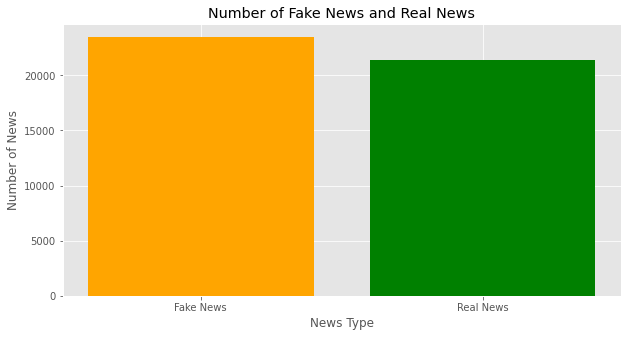

In [ ]:
# show lenght of both dataset -> they are balanced
print("FAKE NEWS DATASET contains "+str(len(fake_news_dataset))+" samples.")
print("REAL NEWS DATASET contains "+str(len(real_news_dataset))+" samples.\n")

# histogram to show number of sample in the 2 dataset -> balanced
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_news_dataset), color='orange')
plt.bar('Real News', len(real_news_dataset), color='green')
plt.title('Number of Fake News and Real News')
plt.xlabel('News Type')
plt.ylabel('Number of News')


For each dataset, the number of samples with a specific subject or publication date was also studied. \
From the figure below, it can be assumed that the validity of a given news (i.e. whether false or real) does not depend on its subject or publication date. \
The lack of correlation between validity and subject or between validity and publication date makes it reasonable to exclude these features from the dataset: if these two features were preserved, they could adversely affect the accuracy of the classifier we intend to construct. 

Text(0, 0.5, 'Number of Fake News')

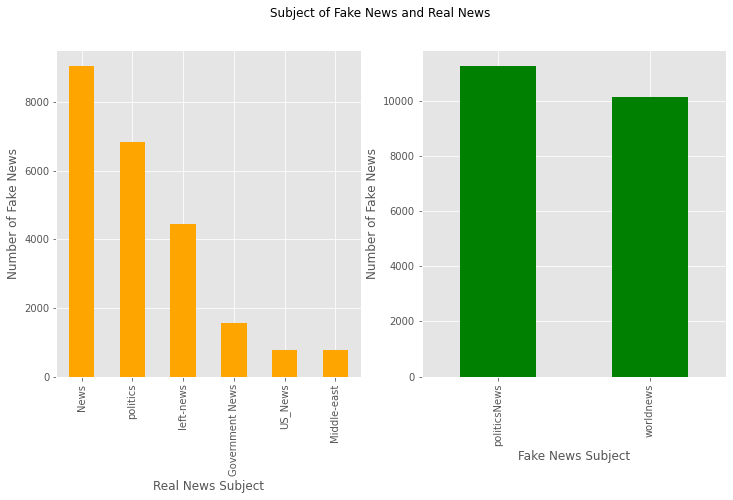

In [ ]:
# Show distribution of news for their subject topic

plt.rcParams['figure.figsize'] = [12, 6]
fig, axes = plt.subplots(1,2)
fake_news_dataset['subject'].value_counts().plot(ax=axes[0], kind = "bar", color='orange')
real_news_dataset['subject'].value_counts().plot(ax=axes[1], kind = "bar", color='green')
plt.suptitle('Subject of Fake News and Real News')
axes[0].set_xlabel('Real News Subject')
axes[0].set_ylabel('Number of Fake News')
axes[1].set_xlabel('Fake News Subject')
axes[1].set_ylabel('Number of Fake News')


Text(0.5, 0.98, 'Date of Fake News and Real News')

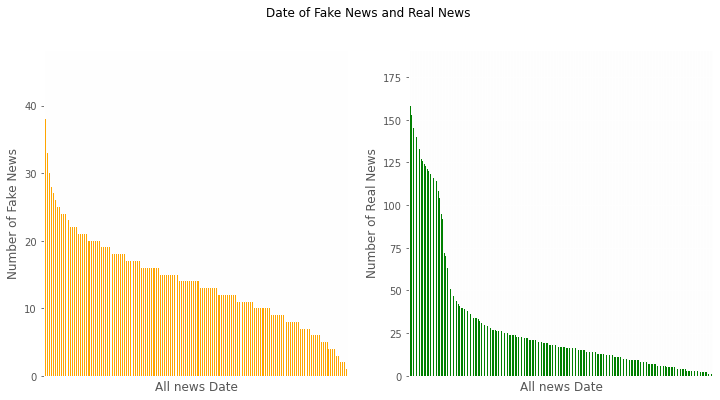

In [ ]:
# Show distribution of news for their pubblication date

fig, axes = plt.subplots(1,2)
fake_news_dataset['date'].value_counts().plot(ax = axes[0], kind="bar", color='orange')
real_news_dataset['date'].value_counts().plot(ax = axes[1], kind="bar", color='green')
axes[0].tick_params(labelbottom = False, bottom = False)
axes[0].set_xlabel('All news Date')
axes[0].set_ylabel('Number of Fake News')
axes[1].tick_params(labelbottom = False, bottom = False)
axes[1].set_xlabel('All news Date')
axes[1].set_ylabel('Number of Real News')
plt.suptitle('Date of Fake News and Real News')


### **2.2. Dataset cleaning**

This section describes some preprocessing techniques applied to the avaiable datasets by means of the `PreprocessDataset()` function. This function takes the 2 datasets as input and transforms them through the following steps:

1. **Class declaration.** A binary label is assigned to each news article: 0 for fake news and 1 for real news. 
2. **Datasets merging.** The two datasets, fake news dataset and real news dataset, have been merged into one dataset containing both fake news and real news.
3. **Features Dropping.** Fetaures considered unnecessary or misleading (such as subject and date) for the classifier have been removed. 
4. **Feature Unification.** Title and text column has been unified into a single text feature. 
5. **Lemmatization.** Using the Lemmatizer provided by the NLTK library each word in the text has been replaced by its lemma when possible. 
6. **Stop word removal.** Using the list of english stop words, made available by the NLTK library, each stop word present in the text was recognized and removed from the text. 
7. **Removal of punctuation marks.** All punctuation marks present in the news were recognized by means of a regular expression and removed from the text.
8. **Conversion of upper case characters.** All upper case characters were converted to lower case.  

When finished, the function returns a final, pre-elaborated dataset cleaned of undesired tokens. 

In [ ]:

stop_words = stopwords.words('english') # load english stop words to recognize it in text
lemmatizer = WordNetLemmatizer()        # create Lemmatizer object
stemmer    = PorterStemmer()            # create Stemmer object

def lemmatize_words(text):
  # use NLTK Lemmatizer object to replace each text word with its lemma
  return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

def stemming_words(text):
  # use NLTK Stemmer object to do stemming 
  return ' '.join(stemmer.stem(word) for word in text.split())

def remove_stopwords(text):
  # use stop words list to recoginze stop words and remove them from text 
  return ' '.join([word for word in nltk.word_tokenize(text) if word not in stop_words])

def remove_punctuations(text):
  # use regex to recoginze punctuation and remove it from text 
  return re.sub(r'[^\w\s]', ' ', text)

def PreprocessDataset (dataset1, dataset2):
  
  # for each dataset add a column to store the target class
  dataset1['class'] = 0 # class 0: fake news
  dataset2['class'] = 1 # class 1: real news

  # merge fake news dataset and real news dataset in a unique dataset 
  dataset = pd.concat([dataset1, dataset2], ignore_index=True, sort=False)

  # delete useless features (like the subject and the data of a news)
  dataset.drop(['subject', 'date'], axis=1, inplace=True)

  # unify features title and text in a single features
  dataset['text'] = dataset['title'] + dataset['text']
  dataset.drop('title', axis=1, inplace=True)

  # dataset['text'] = dataset['text'].apply(stemming_words)     # apply stemmer [not used in this project]
  dataset['text'] = dataset['text'].apply(remove_punctuations)  # apply punctuation remover
  dataset['text'] = dataset['text'].apply(lemmatize_words)      # apply lemmatizer
  dataset['text'] = dataset['text'].apply(remove_stopwords)     # apply stopword remover
  dataset['text'] = dataset['text'].str.lower()                 # apply lower case converter

  return dataset

In [ ]:
news_dataset = PreprocessDataset(fake_news_dataset, real_news_dataset)
display(news_dataset)

,text,class
0,donald trump sends out embarrassing new year e...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes an internet joke ...,0
3,trump is so obsessed he even has obama name co...,0
4,pope francis just called out donald trump duri...,0
...,...,...
44893,fully committed nato back new u s approach afg...,1
44894,lexisnexis withdrew two product chinese market...,1
44895,minsk cultural hub becomes authoritiesminsk re...,1
44896,vatican upbeat possibility pope francis visiti...,1


By extracting the textual content of the first sample from the dataset, we can show how the textual features were pre-processed and cleaned as described above: 

In [ ]:
print(news_dataset.iloc[0]['text'])

donald trump sends out embarrassing new year eve message this disturbingdonald trump wish americans happy new year leave instead give shout enemy hater dishonest fake news medium the former reality show star one job as country rapidly grows stronger smarter i want wish friend supporter enemy hater even dishonest fake news media happy healthy new year president angry pants tweeted 2018 great year america as country rapidly grows stronger smarter i want wish friend supporter enemy hater even dishonest fake news media happy healthy new year 2018 great year america donald j trump realdonaldtrump december 31 2017trump tweet went welll expect what kind president sends new year greeting like despicable petty infantile gibberish only trump his lack decency even allow rise gutter long enough wish american citizen happy new year bishop talbert swan talbertswan december 31 2017no one like calvin calvinstowell december 31 2017your impeachment would make 2018 great year america i also accept regain

### **2.3. Dataset splitting**

Once the dataset has been processed, it needs to be split into 3 different portions according to the split proportion 60:20:20. Each part will be used to train, validate or test the model. \
In particular, the training phase is carried out on 60% of the original dataset that will serve as *Training Set (TR)*. The *Validation Set (VL)* is made by 20% of the original dataset and it is used to fine-tune the model. The last 20% of the original dataset, the *Test Set (TS)*, is used to predict the expected label of the news article based on the trained model. \

The splitting has been easly done by SciKit Learn `split_train_test_split` function. 

However, our deep learning model will not be able to understand words. For this reason, before passing dataset to the model, it is necessary to map each word into an integer.

In order to represent words with integers we firstly have to construct a vocabolary of words that occur in our dataset: since create and use a huge vocabolary of all occurring word could be expensive we decide to put in our vocabolary only the 10000 most frequent words. In this way we fix the vocabolary size up to 10000.

Our vocabulary will contain 10000 indexed words and we can represent each word with its numeric index.
Using word indices, we can map a sequence of words to a sequence of integers; if words not contained in the vocabulary are encountered during the mapping, the OOV (Out Of Vocabulary) token will be used to represent them.

In addition, since the obtained integer sequences have different number of components we apply padding to match all lengths (we fix the max lengths of a sequence up to 256).


Vocabulary construction, mapping from words to integer and sequence padding has been done using the Keras `tokenizer` object.

All this steps are executed by means of `SplitDataset()` function that returns a training set, a validation set and a test set ready for being passed to the model. 


In [ ]:
def SplitDataset (dataset, vocab_size, max_lenght):
  
  features = dataset['text']  # define which column are features
  targets  = dataset['class'] # define which column are target class

  # dataset = train set (60%) + validation set (20%) + test set (20%)

  # split the data in Training set and temporary remaining set
  x_train, x_temp, y_train, y_temp = train_test_split(features, targets, train_size=0.6)
  # split the data in temporary remaining set in Validation set and Test set
  x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

  # create tokenizer object and fit it to dataset 
  tokenizer = Tokenizer(num_words = vocab_size,
                        oov_token='OOV')
  
  tokenizer.fit_on_texts(x_train) 
  tokenizer.fit_on_texts(x_val)
  tokenizer.fit_on_texts(x_test)

  # trasform text to sequence for data in train, validation and test sets
  x_train = tokenizer.texts_to_sequences(x_train)
  x_val   = tokenizer.texts_to_sequences(x_val)
  x_test  = tokenizer.texts_to_sequences(x_test)

  # pad sequence for data in train, validation and test sets
  x_train = pad_sequences(x_train, padding='post', maxlen=max_length) # here max_lenght
  x_val   = pad_sequences(x_val, padding='post', maxlen=max_length)
  x_test  = pad_sequences(x_test, padding='post', maxlen=max_length)

  return tokenizer, x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
vocab_size = 10000  # vocabolary size fixed to 10.000
max_length = 256    # max length of sequence fixed to 256

# obtain dataset splitting (TR, VL, TS) and tokenizer object
tokenizer_obj, x_tr, x_vl, x_ts, y_tr, y_vl, y_ts = SplitDataset(news_dataset, vocab_size, max_length)

print("Number of sample in TR: "+ str(len(x_tr)))
temp = y_tr.value_counts()
print("\t Number of sample with class 0: ", temp[0])
print("\t Number of sample with class 1: ", temp[1])
temp = y_vl.value_counts()
print("\nNumber of sample in VL: "+ str(len(x_vl)))
print("\t Number of sample with class 0: ", temp[0])
print("\t Number of sample with class 1: ", temp[1])
temp = y_ts.value_counts()
print("\nNumber of sample in TS: "+ str(len(x_ts)))
print("\t Number of sample with class 0: ", temp[0])
print("\t Number of sample with class 1: ", temp[1])

Number of sample in TR: 26938
	 Number of sample with class 0:  14077
	 Number of sample with class 1:  12861

Number of sample in VL: 8980
	 Number of sample with class 0:  4661
	 Number of sample with class 1:  4319

Number of sample in TS: 8980
	 Number of sample with class 0:  4743
	 Number of sample with class 1:  4237


Training set, Validation set and Test set are all balanced dataset. 

## **3. Model Architecture**

### **3.1. Related work**

Since the aim of this project is to built a binary classifier able to process textual data to identify fake news article, it is necessary to refer to some deep learning methods for linguistic modelling. \
Deep learning offers different models for fake news detection task: Convolutional Neural Network (CNN) and Recurrent Neural Network (RNN), LSTM and Bidirectional LSTM are all valid architectures to handle this classification problem. 
For this reason, we need to select an architecture to use among the possible ones. 

Creating, training and testing all the above architectures to identify the best performing one would have been too time-consuming; in order to select the "best architecture" in a smarter way we have referred to a paper presented at the *International Conference on Recent Trends in Advanced Compunting (2019)* titled [Fake News Detection using Bi-directional LSTM-Recurrent Neural Network](https://www.sciencedirect.com/science/article/pii/S1877050920300806) and written by P. Bahad, P. Saxena ,R. Kamal. 

This paper reports the stages of an experiment carried out to identify which architecture among CNN, Vanilla RNN, LSTM and Bi-directional LSTM is able to achieve higher accuracy score in the evaluation phase for a fake news detection task.

All these mentioned models were trained on two different datasets and the obtained results show how a Bi-directional LSTM-RNN model is significantly more effective than the other proposals; it is also able to works well for the balanced and imbalanced high dimensional news dataset. 

The conclusions drawn in this paper, and reported here,  were the starting point for this project and motivated the decision to to carry out this task throught Bi-directional LSTM architecture.

This article also suggested some additional techniques that helps to achive higher performance if they are adopted in model building and training phases:
* RMSprop adaptive learning optimization algorithm is recommended to obtain faster convergence and higher accury score;
*  Pre-trained GloVe word embeddings could be useful to boost model performance.

This supplementary strategy implemented also in this project will be further explored and described in the following subsections.

### **3.2. Glove pretrained embeddings**

GloVe is an unsupervised learning algorithm for obtaining vector representations for words; its training results in word embeddings that can be used from different model to improve their performance. 

In this task we will use Glove pre-trained embeddings in the embeddings layer of our model: in particolar, we use Glove embeddings with dimension equal to 50. 

More in details, we use the implemented `GloveEmbeddings()` function to prepare a Glove embeddings matrix that needs to be passed to our model. [*]\
Given the dataset consisting of words and the corresponding embeddings already trained with the Glove algorithm; the implemented function randomly initializes a matrix of size: vocabulary dimension x embeddings dimension, i.e. 10000 x 50. 

This Glove embeddings matrix will be updated as follows:
- given the i-th word in our vocabulary, the i-th row of the matrix will be replaced by the vector corresponding to the word embeddings of that word;
- this procedure is repeated for all the words in the vocabulary;
- at the end of the iterations, the function returns the final glove embbeddings matrix, ready to be passed to the model. 

[*] The guidelines for handling Glove word embbeddings were taken from the GitHub repository [Introduction to Keras](https://github.com/diningphil/Intro_Keras) suggested during the lessons. 

In [ ]:
def GloveEmbeddings (tokenizer, vocab_size, embedding_dim ):
  
  #create a dictionary to map word to its pretrained embedding
  word_to_embedding = {} 
  # we use Glove embedding dimension  = 50
  with open(os.path.join('glove.6B.50d.txt'),'r',encoding='utf8') as f:
    for line in f.readlines():
      # for each word update dictionary with its embeddings
      values = line.split()
      word = values[0]
      emb_vector = np.asarray(values[1:], dtype='float32')
      word_to_embedding[word] = emb_vector

  id_to_word = tokenizer.index_word # load word index vocabolary
  # initiliaze word embeddings matrix (10000 x 50 = vocabolary size x embeddings dimension)
  glove_emb_matrix = np.random.randn(vocab_size, embedding_dim)

  # for each item in vocabolary 
  for i in range(1, vocab_size): # start from 1 to skip the 0 value used for padding
    # search word in vocabolary by id
    w = id_to_word[i]    
    #if exisists a pretrained embedding for the given word update glove embedding matrix
    if w in word_to_embedding:
      glove_emb_matrix[i,:] = word_to_embedding[w]
  
  return glove_emb_matrix
  

In [ ]:
embedding_dim = 50
glove_embeddings_matrix = GloveEmbeddings(tokenizer_obj, vocab_size, embedding_dim)

print("Glove embeddings matrix:\n", glove_embeddings_matrix)
print("\nShape Glove embeddinngs matrix: ", glove_embeddings_matrix.shape)

Glove embeddings matrix:
 [[ 0.21299428 -0.33613431  0.01565431 ...  1.31779468 -0.45108596
  -0.1753735 ]
 [ 1.31937275 -0.77210781  0.03112927 ...  1.61566304  0.51760194
  -0.53535974]
 [ 0.45769     0.85191     0.31097999 ... -0.74225998  0.77052999
   0.26394001]
 ...
 [ 1.91059995 -1.24199998 -0.53617001 ...  0.21683    -0.49362001
  -1.40890002]
 [-0.10706    -1.10689998  0.29874    ...  0.10797     0.37204999
   0.49700999]
 [ 0.51941001 -0.2536     -0.13076    ...  1.27139997  0.40898001
   0.011436  ]]

Shape Glove embeddinngs matrix:  (10000, 50)


### **3.3. Model implementation**

The following part will describe the architecture of the model used for this fake news detection task. 

The model is structured on three layers: an input layer, an hidden layer and an output layer.

1. **Input layer** \
The input layer is an embedding layer, used to represent each word (represented like an integer) as a vector in a dense space of fixed size. Here, the keras initializer generates tensors with constant values taken from the already computed Glove Embeddings Matrix. \
The input dimension is the size of the vocabulary and the output dimension is the dimension of the embedding. \
Moreover a special attribute is used to remember that the input value 0 is a special "padding" value that should be masked out.

2. **Hidden layer** \
The hidden layer is a Bi-direction LSTM layer, for which we specify the number of units (that is equal for both forward and backward direction). We add some dropout and recurrent dropout to prevent overfitting. Like in keras deafult, the activation function is the TanH and the recurrent activation function is the sigmoid. Others LSTM and Bi-direction LSTM argument are left unchanged (keras deafult value). 

3. **Output layer.**
The output layer, that is a simple dense layer with 1 unit and sigmoid activation function, maps the values between 0 and 1.

This model use RMSprop optimizer (the learning rate needs to be specified), Binary Cross-Entropy as loss function and accuracy as evaluation metric. 

This architecture was built using Keras through the implemented `BuiltModel()` function. 

Model training is performed by the `TrainModel()` function. \
In the training phase, the maximum number of epochs and the batch size must be defined. To avoid overfitting, early stop conditions have been added: if the validation loss increases for 2 successive epochs, the training is stopped and the model weights are restored. \
In addition, a useful method was implemented to weight the loss of each samples according to their class. The employment of this method is optional and depends on the Boolean value of the weightloss parameter. It is not currently used and will be explored and described in Section 5.3. 

In [ ]:
def BuiltModel(vocab_size, embedding_dim, glove_matrix, n_units, learning_rate):
  
  model = Sequential()
  #input layer: Glove Embeddings
  model.add(Embedding(vocab_size, 
                      embedding_dim,
                      mask_zero = True,
                      embeddings_initializer = Constant(glove_matrix),
                      trainable = True))
  #hidden layer: Bidirectional LSTM
  model.add(Bidirectional(LSTM(units=n_units,
                               dropout=0.2,
                               recurrent_dropout=0.2,)))
  #output layer: Dense
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), #from_logits=True),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate),
                metrics = ['accuracy'])
          
  return model


In [ ]:
def TrainModel (model, x_train, y_train, x_val, y_val, weightloss, bs, retrain):

  # early stopping conditions
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # monitor validation loss
                                                patience=2,        
                                                restore_best_weights=True)
  if weightloss == True:
    # compute class wights
    class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                      classes = np.unique(y_train),
                                                      y = y_train)
    # store obtained class weight in a dictionary                                                   
    class_weights = dict(zip(np.unique(y_train), class_weights))
    print("The class weights used are:\n", class_weights)

    #train the model 
    history = model.fit(x_train, y_train, 
                        epochs = 10,
                        validation_data = (x_val, y_val),
                        batch_size = int(bs),
                        shuffle = True, 
                        callbacks = [early_stop],
                        class_weight = class_weights)
  else:
    # train the model
    history = model.fit(x_train, y_train, 
                        epochs = 10,
                        validation_data = (x_val, y_val),
                        batch_size = int(bs),
                        shuffle = True, 
                        callbacks = [early_stop])
  
  history_dict = history.history
  epoch = history.epoch

  if retrain ==True: # if last retrain
    return model, history_dict, epoch
  else:
    return history_dict

## **4. Model Selection and Model Assestment**

Once the model architecture has been outlined, it is necessary to train it with different configurations of hyperparameters and select as the best model the one able to achieve a lower validation loss. \
In this model selection stage, performed with the simple Hold-Out technique, the whole hyper-parameter space was not fully investigated.

Early experiments showed that our simple architecture - with 1 embedding layer, 1 bi-directional LSTM layer and 1 output layer - can easily achieve good accuracy/validation loss. 
In fact, if we use a small number of hidden units (such as 10 units), mini-batch 128 and a default value of the keras learning rate, we already achieve good performance on the validation set. The model seemed just a bit in underfitting and the learning curve a little unstable. 

For this reason, we decided to pay attention only to the number of units, the value of the learning rate and the size of the mini batch, trying to study the influence of these factors on performance. 
Therefore, we can state that the grid search carried out is not exhaustive: some configurations not examined due to the long time required for a more complete grid search could have led to the selection of an even better model. 

In particular, we analyse the behaviour of models with:
- number of units equal to 10 or 25;
- minibatch size set up to 128;
- learning rate of 0.001 or 0.0001;
- LSTM droput and recurrent LSTM drop out set up to 0.2-0.2;

Exploring these hyperparameter configurations, we select as the best model the one with 10 units and learning rate value 0.001; mini-batch size and dropout are already fixed.
This hyper-parameter setting allows us to achieve 99% accuracy during training and validation phase.

In [ ]:
def ModelSelection (x_tr, y_tr, x_vl, y_vl, vocab_size, embedding_dim, glove_embeddings_matrix):
  
  # hyperparameter configuration = [n° units, batch size, learning rate]
  param_config = {0: [25, 128, 0.001],
                  1: [25, 128, 0.0001],
                  2: [10, 128, 0.001],
                  3: [10, 128, 0.0001]}
  
  model_loss = [] # store here last validation loss otained for each model 
  
  # train a model for each available hyperparameters configuration
  for i in range(len(param_config)):
    config_value = param_config[i]
    print("\nTrain "+str(i+1)+"° model with hyperparameter configuration", config_value)
    model = BuiltModel(vocab_size, embedding_dim, glove_embeddings_matrix, config_value[0], config_value[2])
    history_dict = TrainModel (model, x_tr, y_tr, x_vl, y_vl, False, config_value[1], False)
    val_loss = history_dict['val_loss']
    model_loss.append(val_loss[-1])
  
  # find model with the lowe validation loss
  best_loss = min(model_loss)
  print("\nThe lower obbtained validation loss is: "+str(best_loss))
  best_config = model_loss.index(best_loss)
  
  # retrain the best model 
  config_value = param_config[best_config]
  print("\nRetrain best model with hyperparameter configuration:", config_value)
  model = BuiltModel(vocab_size, embedding_dim, glove_embeddings_matrix, config_value[0], config_value[2])
  model.summary()
  model, history_dict, epoch = TrainModel (model, x_tr, y_tr, x_vl, y_vl, False, config_value[1], True)

  return model, history_dict, epoch, config_value


In [ ]:
BiLSTM, history_dict, epochs, config_value = ModelSelection(x_tr, y_tr, x_vl, y_vl, vocab_size, embedding_dim, glove_embeddings_matrix)

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']



Train 1° model with hyperparameter configuration [25, 128, 0.001]
Epoch 1/10
211/211 [==============================] - 184s 839ms/step - loss: 0.1982 - accuracy: 0.9271 - val_loss: 0.0873 - val_accuracy: 0.9657
Epoch 2/10
211/211 [==============================] - 175s 831ms/step - loss: 0.0724 - accuracy: 0.9748 - val_loss: 0.0650 - val_accuracy: 0.9775
Epoch 3/10
211/211 [==============================] - 175s 829ms/step - loss: 0.0462 - accuracy: 0.9844 - val_loss: 0.0406 - val_accuracy: 0.9864
Epoch 4/10
211/211 [==============================] - 182s 865ms/step - loss: 0.0330 - accuracy: 0.9890 - val_loss: 0.0355 - val_accuracy: 0.9878
Epoch 5/10
211/211 [==============================] - 175s 831ms/step - loss: 0.0245 - accuracy: 0.9916 - val_loss: 0.0653 - val_accuracy: 0.9794
Epoch 6/10
211/211 [==============================] - 179s 851ms/step - loss: 0.0182 - accuracy: 0.9938 - val_loss: 0.0349 - val_accuracy: 0.9908
Epoch 7/10
211/211 [==============================] - 174

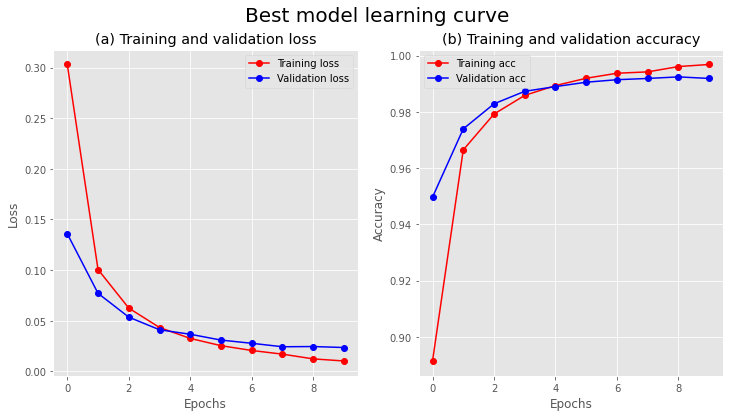

<Figure size 1296x864 with 0 Axes>

In [ ]:
# Plot best model learing curve for training and validation
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("Best model learning curve", size=20)
plt.figure(figsize=(18,12))

ax1.plot(epochs, loss, 'ro-', label='Training loss')
ax1.plot(epochs, val_loss, 'bo-', label='Validation loss')
ax1.set_title('(a) Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'ro-', label='Training acc')
ax2.plot(epochs, val_acc, 'bo-', label='Validation acc')
ax2.set_title('(b) Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In model assestment phase we use simple Hold-Out technique: here, the model has been evaluated based on the its prediction made over the Test set (TS). \
Results show that our model can reach 99% of accuracy in testing phase. 

In [ ]:

def ModelAssestment (model, x_test, y_test):
  model.evaluate(x_test, y_test)
  pred = model.predict(x_test)

  binary_predictions = []
  for i in pred:
      if i >= 0.5:
          binary_predictions.append(1)
      else:
          binary_predictions.append(0) 

  acc = accuracy_score(binary_predictions, y_test)    # accuracy 
  pre = precision_score(binary_predictions, y_test)   # precision
  rec = recall_score(binary_predictions, y_test)      # recall
  c_m = confusion_matrix(binary_predictions, y_test)  # confusion matrix

  return acc, pre, rec, c_m

In [ ]:
accuracy, precision, recall, confusionmatrix = ModelAssestment(BiLSTM, x_ts, y_ts)
print('\nAccuracy on test set:', accuracy)
print('Precision on test set:', precision)
print('Recall on test set:', recall, "\n")
print('Confusion matrix:')
df = pd.DataFrame(confusionmatrix)
df.columns = ['Actual Fake News', 'Actual Real News']
df = df.rename(columns={'0': 'Actual Fake News', '1':'Actual Real News'}, index={0: 'Predicted Fake News', 1:'Predicted Real News'})
display(df)

281/281 [==============================] - 16s 58ms/step - loss: 0.0251 - accuracy: 0.9925

Accuracy on test set: 0.9925389755011136
Precision on test set: 0.988907245692707
Recall on test set: 0.995249406175772 

Confusion matrix:


,Actual Fake News,Actual Real News
Predicted Fake News,4723,47
Predicted Real News,20,4190


The confusion matrix illustrates how the model trained on a balanced TR set predict, more or less, the same number of misclassified samples for each class.


### **4.1. Best model: brief overview**


| Model Topology |   |
|-------|-------------|
| | |
|  ***(1) INPUT LAYER***|
| Layer type | Embeddings layer |
| Input dimension | 10000 (Vocabolary size) |
| Output dimension | 50 (Embeddings dimension)|
| Mask zero | True|
| Embeddings initializer | Glove embeddings matrix|
| | |
| ***(2) HIDDEN LAYER*** |
| N°of Hidden layer | 1 |
| Layer type | Bi-Directional LSTM |
| N° of units in Forward | 10 |
| N° of units in Backward | 10 |
| LSTM Activation Function | TanH (Keras Default)|
| LSTM Recurrent Activation Function | Sigmoid (Keras Default)|
| LSTM Drop out - Recurrent Drop Out | 0.2 - 0.2 |
| Others LSTM or Bi-LSTM argument | Keras Default |
| | |
| ***(3) OUTPUT LAYER*** |
| Layer type | Dense |
| Number of units | 1 |
| Activation function | Sigmoid function |



| Main Training Features  | | 
|---------------- | ------|
| Optimizer      | RMSprop |
|Learning rate (LR)  | 0.001 |
|Momentum | False|
|Regularization | False|
|Other RMSprop parameter | Keras default value|
|Mini-batch size  | 128 |
|Max n° epochs |  10 |   
|Loss Function | Binary Cross-Entropy|
|Early stopping (ES)| True
|ES monitor | Validation loss
|ES Patience | 2 
|Loss weighteing | Avaiable but not used |



|Model Performance | | | |
|------|-------|---|--|
|  | **Training** | **Validation** | **Testing** |
| Accuracy | 0.996 | 0.991 | 0.992|
| Loss | 0.0103|0.0236|0.0251|


## **5. Dealing with imbalanced training set**

In the previous section, we observed that the model trained on a well-balanced training set is able to optimally predict the target class of a new example in a balanced test set. \
In this section we want to study the behaviour of the model trained on an imbalanced training set and tested on a balanced test set. \
Next, some strategies will be adopted to make the training robust to imbalances.

### **5.1. Generate imbalanced training set**

First of all, we need to create an imbalanced training set in which the number of samples belonging to a certain class is significantly higher than the other. Therefore, we can have a TR set imbalanced towards class 0 (containing more fake news than real news) as well as we can have a TR set imbalanced towards class 1 (containing more real news than fake news). 

In the production of the imbalanced datasets, particular attention was paid to keeping the size of the new genereted dataset equals to the size of the original training set: this choice was made in order to prevent a different number of samples in the training set from affecting the performance of the model in any way. 

The `CreateImbalancedDatasets()` function takes the original TR set as input and returns two imbalanced TR set with the same number of samples as the original TR. \
The proportion of samples in the original TR is 50:50 and we want to obtain highly imbalanced TR with proportions 95:5. \
Hence, the following procedure was adopted for the creation of imbalanced TR sets:
- the number of samples belonging to one class was increased from 50% to 95%: new samples were generated by means of the `RandomOverSampler()` object provided by the Imbalance Learn library.
- The number of samples belonging to the remaining class was decreased from 50% to 5%: some samples were discarted by means of the `RandomUnderSampler()` object provided by the Imbalance Learn library.

This procedure finally results in 2 imbalanced TR set:
- the 1° TR set imbalanced towards class 1 contains the same number of total samples as the original TR; 95% of this samples belongs to class 1 and 5% belongs to class 0 (thus more real news than fake news).
- the 2° TR set imbalanced towards class 0 contains the same number of total samples as the original TR set; 95% of this samples belongs to class 0 and 5% to class 1 (thus more fake news than real news).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def CreateImbalancedDatasets (x_train, y_train):

  counter_sample = y_tr.value_counts()
  n_fake, n_real =  counter_sample[0], counter_sample[1]
  # goal: obtain an imbalanced training set with more fake news then real news

  new_n_fake = 1347   # 5% of total number of samples 
  new_n_real = 25591  # 95% of total number of samples 
  
  # oversampling class 1 and underampling class 0 
  rous_ratio = {0:n_fake, 1:new_n_real}
  rous = RandomOverSampler(sampling_strategy = rous_ratio)
  x_1, y_1 = rous.fit_resample(x_train, y_train)
  rous_ratio = {0:new_n_fake, 1:new_n_real}
  rous = RandomUnderSampler(sampling_strategy = rous_ratio)
  x_1, y_1 = rous.fit_resample(x_1, y_1)

  new_n_fake = 25591 # 95% of total number of samples 
  new_n_real = 1347 # 5% of total number of samples 
  
  # oversampling class 0 and underampling class 1 
  rous_ratio = {0:new_n_fake, 1:n_real}
  rous = RandomOverSampler(sampling_strategy = rous_ratio)
  x_2, y_2 = rous.fit_resample(x_train, y_train)
  rous_ratio = {0:new_n_fake, 1:new_n_real}
  rous = RandomUnderSampler(sampling_strategy = rous_ratio)
  x_2, y_2 = rous.fit_resample(x_2, y_2)

  
  return x_1, y_1, x_2, y_2

In [ ]:
x1, y1, x2, y2 = CreateImbalancedDatasets(x_tr, y_tr)

print("Total number of sample in original TR set: "+str(len(y_tr)))
print("Number of sample in each class:")
print(y_tr.value_counts(), "\n")

print("Total number of sample in 1° imbalanced TR set: "+str(len(y1)))
print("Number of sample in each class:")
print(y1.value_counts(), "\n")

print("Total number of sample in 2° imbalanced TR set: "+str(len(y2)))
print("Number of sample in each class:")
print(y2.value_counts(), "\n")


Total number of sample in original TR set: 26938
Number of sample in each class:
0    14077
1    12861
Name: class, dtype: int64 

Total number of sample in 1° imbalanced TR set: 26938
Number of sample in each class:
1    25591
0     1347
Name: class, dtype: int64 

Total number of sample in 2° imbalanced TR set: 26938
Number of sample in each class:
0    25591
1     1347
Name: class, dtype: int64 



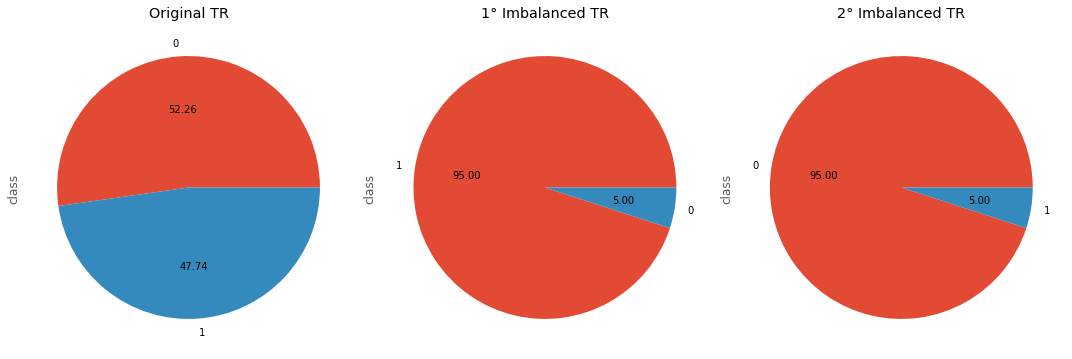

In [ ]:
# show pie graph of different TR proportion
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
y_tr.value_counts().plot.pie(autopct="%.2f", ax=axs[0])
axs[0].set_title("Original TR")
y1.value_counts().plot.pie(autopct="%.2f", ax=axs[1])
axs[1].set_title("1° Imbalanced TR")
y2.value_counts().plot.pie(autopct="%.2f", ax=axs[2])
axs[2].set_title("2° Imbalanced TR")
fig.tight_layout()

### **5.2. Evaluate model trained with imbalanced training set**

Given the best hyper-parameter configuration found in Section 4, the best model was trained in parallel on each one of the 2 imbalanced TR sets and tested on the balanced TS created in Section 2.3 and previously used in model assestment. 



In [ ]:
# Train model on TR set with more real news than fake news
print("Training phase")
model1 = BuiltModel(vocab_size, embedding_dim, glove_embeddings_matrix, config_value[0], config_value[2])
model1, history_dict1, epoch1 = TrainModel (model1, x1, y1, x_vl, y_vl, False, config_value[1], True)
print("Testing phase")
accuracy1, precision1, recall1, confusionmatrix1 = ModelAssestment(model1, x_ts, y_ts)
print('\nAccuracy on test set:', accuracy1)
print('Precision on test set:', precision1)
print('Recall on test set:', recall1, "\n")
print('Confusion matrix:')
df = pd.DataFrame(confusionmatrix1)
df.columns = ['Actual Fake News', 'Actual Real News']
df = df.rename(columns={'0': 'Actual Fake News', '1':'Actual Real News'}, index={0: 'Predicted Fake News', 1:'Predicted Real News'})
display(df)

Training phase
Epoch 1/10
211/211 [==============================] - 153s 693ms/step - loss: 0.1623 - accuracy: 0.9459 - val_loss: 0.5130 - val_accuracy: 0.7891
Epoch 2/10
211/211 [==============================] - 145s 686ms/step - loss: 0.0463 - accuracy: 0.9842 - val_loss: 0.2444 - val_accuracy: 0.9085
Epoch 3/10
211/211 [==============================] - 142s 674ms/step - loss: 0.0300 - accuracy: 0.9903 - val_loss: 0.1908 - val_accuracy: 0.9347
Epoch 4/10
211/211 [==============================] - 143s 676ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.1472 - val_accuracy: 0.9521
Epoch 5/10
211/211 [==============================] - 143s 676ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.1087 - val_accuracy: 0.9643
Epoch 6/10
211/211 [==============================] - 143s 678ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.0994 - val_accuracy: 0.9705
Epoch 7/10
211/211 [==============================] - 142s 674ms/step - loss: 0.0075 - accuracy: 0.9978 - val

,Actual Fake News,Actual Real News
Predicted Fake News,4498,16
Predicted Real News,245,4221


In [ ]:
# Train model on TR set with more fake news than real news
print("Training phase")
model2 = BuiltModel(vocab_size, embedding_dim, glove_embeddings_matrix, config_value[0], config_value[2])
model2, history_dict2, epoch2 = TrainModel (model2, x2, y2, x_vl, y_vl, False, config_value[1], True)
print("Testing phase")
accuracy2, precision2, recall2, confusionmatrix2 = ModelAssestment(model2, x_ts, y_ts)
print('\nAccuracy on test set:', accuracy2)
print('Precision on test set:', precision2)
print('Recall on test set:', recall2, "\n")
print('Confusion matrix:')
df = pd.DataFrame(confusionmatrix2)
df.columns = ['Actual Fake News', 'Actual Real News']
df = df.rename(columns={'0': 'Actual Fake News', '1':'Actual Real News'}, index={0: 'Predicted Fake News', 1:'Predicted Real News'})
display(df)

Training phase
Epoch 1/10
211/211 [==============================] - 199s 759ms/step - loss: 0.1590 - accuracy: 0.9549 - val_loss: 0.4438 - val_accuracy: 0.8437
Epoch 2/10
211/211 [==============================] - 150s 709ms/step - loss: 0.0525 - accuracy: 0.9829 - val_loss: 0.2904 - val_accuracy: 0.8988
Epoch 3/10
211/211 [==============================] - 147s 697ms/step - loss: 0.0337 - accuracy: 0.9903 - val_loss: 0.2558 - val_accuracy: 0.9089
Epoch 4/10
211/211 [==============================] - 147s 697ms/step - loss: 0.0224 - accuracy: 0.9930 - val_loss: 0.1515 - val_accuracy: 0.9473
Epoch 5/10
211/211 [==============================] - 146s 693ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 0.1309 - val_accuracy: 0.9555
Epoch 6/10
211/211 [==============================] - 146s 693ms/step - loss: 0.0121 - accuracy: 0.9960 - val_loss: 0.1985 - val_accuracy: 0.9384
Epoch 7/10
211/211 [==============================] - 146s 691ms/step - loss: 0.0088 - accuracy: 0.9974 - val

,Actual Fake News,Actual Real News
Predicted Fake News,4738,404
Predicted Real News,5,3833


As can be seen from the results obtained here, the model's performance in the predictive phase gets worse if it has been trained on imbalanced TR set. The model trained in this way tends to go into overfitting early: more specifically, the model loses its ability to generalize well over new data.
To confirm this, we can observe that early stopping comes into action in both cases when the validation loss begins to increase, thus interrupting the subsequent training epochs.   
However, as the accuracy never falls below 0.9, we can say that the implemented model is already quite robust to highly imbalanced datasets. \

Looking at the obtained confusion matrices, we can easily state that the greater number of incorrect predictions are made on samples belonging to the under-represented class; these samples are misclassified with samples coming from the most represented class. 

### **5.3. Improving model robustness by weighting loss function**

In this section we want to present a strategy to try to raise the final performance of the model when trained on imbalanced datasets; in other words, we want to make the model robust to imbalanced TR sets. 

Our goal is to tell the model to pay more attention to samples coming from an under-represented class during training phase: we can do this by passing to the `model.fit()` function the `class_weight` attribute: this attribute's value is a dictionary that maps class indices (integers) to a weight (float) value, used for weighting the loss function (during training only).

To get a dictionary of class weights, we must first calculate the respective weights of each class: these weights are computed using the `compute_class_weight()` function imported from the SciKit Learn library. They are given by dividing the total number of samples by the product between the number of classes and number of occurrences of each value in the list of samples target class. 

We can use this strategy by passing the attribute `weightloss == True` when calling the `TrainModel()` function, and the following piece of code will be executed. 

```python
if weightloss == True:
    # compute class wights
    class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                      classes = np.unique(y_train),
                                                      y = y_train)
    # store obtained class weight in a dictionary                                                   
    class_weights = dict(zip(np.unique(y_train), class_weights))
    print("The class weights used are:\n", class_weights)

    #train the model 
    history = model.fit(x_train, y_train, 
                        epochs = 10,
                        validation_data = (x_val, y_val),
                        batch_size = int(bs),
                        shuffle = True, 
                        callbacks = [early_stop],
                        class_weight = class_weights) # here we pass class_weight
```

We report here the results obtained by training the model on both imbalanced training sets using the loss weighting technique. 

In [ ]:
# Train model on TR set with more real news than fake news
print("Training phase")
model1 = BuiltModel(vocab_size, embedding_dim, glove_embeddings_matrix, config_value[0], config_value[2])
model1, history_dict1, epoch1 = TrainModel (model1, x1, y1, x_vl, y_vl, True, config_value[1], True)
print("Testing phase")
accuracy1, precision1, recall1, confusionmatrix1 = ModelAssestment(model1, x_ts, y_ts)
print('\nAccuracy on test set:', accuracy1)
print('Precision on test set:', precision1)
print('Recall on test set:', recall1, "\n")
print('Confusion matrix:')
df = pd.DataFrame(confusionmatrix1)
df.columns = ['Actual Fake News', 'Actual Real News']
df = df.rename(columns={'0': 'Actual Fake News', '1':'Actual Real News'}, index={0: 'Predicted Fake News', 1:'Predicted Real News'})
display(df)

Training phase
The class weights used are:
 {0: 9.999257609502598, 1: 0.5263178461177758}
Epoch 1/10
211/211 [==============================] - 151s 686ms/step - loss: 0.3166 - accuracy: 0.9199 - val_loss: 0.1680 - val_accuracy: 0.9389
Epoch 2/10
211/211 [==============================] - 144s 680ms/step - loss: 0.1274 - accuracy: 0.9622 - val_loss: 0.1167 - val_accuracy: 0.9566
Epoch 3/10
211/211 [==============================] - 144s 680ms/step - loss: 0.0792 - accuracy: 0.9778 - val_loss: 0.0871 - val_accuracy: 0.9693
Epoch 4/10
211/211 [==============================] - 151s 716ms/step - loss: 0.0505 - accuracy: 0.9854 - val_loss: 0.0819 - val_accuracy: 0.9698
Epoch 5/10
211/211 [==============================] - 144s 683ms/step - loss: 0.0316 - accuracy: 0.9906 - val_loss: 0.0605 - val_accuracy: 0.9786
Epoch 6/10
211/211 [==============================] - 145s 685ms/step - loss: 0.0242 - accuracy: 0.9938 - val_loss: 0.0566 - val_accuracy: 0.9806
Epoch 7/10
211/211 [==============

,Actual Fake News,Actual Real News
Predicted Fake News,4646,48
Predicted Real News,97,4189


In [ ]:
# Train model on TR set with more fake news than real news
print("Training phase")
model2 = BuiltModel(vocab_size, embedding_dim, glove_embeddings_matrix, config_value[0], config_value[2])
model2, history_dict2, epoch2 = TrainModel (model2, x2, y2, x_vl, y_vl, True, config_value[1], True)
print("Testing phase")
accuracy2, precision2, recall2, confusionmatrix2 = ModelAssestment(model2, x_ts, y_ts)
print('\nAccuracy on test set:', accuracy2)
print('Precision on test set:', precision2)
print('Recall on test set:', recall2, "\n")
print('Confusion matrix:')
df = pd.DataFrame(confusionmatrix2)
df.columns = ['Actual Fake News', 'Actual Real News']
df = df.rename(columns={'0': 'Actual Fake News', '1':'Actual Real News'}, index={0: 'Predicted Fake News', 1:'Predicted Real News'})
display(df)

Training phase
The class weights used are:
 {0: 0.5263178461177758, 1: 9.999257609502598}
Epoch 1/10
211/211 [==============================] - 155s 694ms/step - loss: 0.3244 - accuracy: 0.9109 - val_loss: 0.1641 - val_accuracy: 0.9378
Epoch 2/10
211/211 [==============================] - 146s 690ms/step - loss: 0.1245 - accuracy: 0.9580 - val_loss: 0.1059 - val_accuracy: 0.9609
Epoch 3/10
211/211 [==============================] - 146s 691ms/step - loss: 0.0796 - accuracy: 0.9754 - val_loss: 0.0947 - val_accuracy: 0.9658
Epoch 4/10
211/211 [==============================] - 145s 687ms/step - loss: 0.0526 - accuracy: 0.9845 - val_loss: 0.0719 - val_accuracy: 0.9739
Epoch 5/10
211/211 [==============================] - 145s 686ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.0792 - val_accuracy: 0.9735
Epoch 6/10
211/211 [==============================] - 145s 687ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.0600 - val_accuracy: 0.9795
Epoch 7/10
211/211 [==============

,Actual Fake News,Actual Real News
Predicted Fake News,4665,79
Predicted Real News,78,4158


By using the loss weighting function and training the model in parallel on both imbalanced TR sets, we can see that performance in the prediction phase improves: the accuracy score on the test set is higher and the number of errors made on the least represented class is decreased. \
Morever we can observe that the number of misclassified samples for each class is now perfectly well-balanced.

By repeating the training and testing several times, we obtain the following average accuracy values in the evaluation phase.

| | Accuracy on balance Test Set |
|--| ------|
|Model trained on balanced TR|~ 0.99 |
|Model trained on 1° imbalanced TR |~ 0.96|
|Model trained on 2° imbalanced TR | ~ 0.96|
|Model trained on 1° imbalanced TR with Loss weighting|~ 0.98|
|Model trained on 2° imbalanced TR with Loss weighting|~ 0.98|



---


## **6. Conclusion and further developments**

This work aimed to show how the choice of a Bi-directional LSTM Recurrent Neural Network is a winning choice to solve a fake news detection task. Indeed, this type of architecture, which allows an input sequence to be looked from start to end and from end to start at the same time, seems to be advantageous for text classification tasks where sequential modelling is fundamental.

Since we are working with textual data, it is always worth remembering that an initial cleaning and pre-processing of the dataset with typical NLP methods is necessary to improve the future behaviour of the model.

Still speaking about NLP methods, we can say that the use of pre-trained word embeddings ensured our model excellent generalization capabilities.

Regarding the handling of imbalanced training sets, we can conclude that weighting the loss function of each sample according to its class proved to be a good strategy (although the performance of such a model is not as good as that of a model trained on an unbalanced training set).

Given the conclusions just drawn, we can anticipate some interesting future developments:
- Since the grid search performed in the model selection phase was not exhaustive, it might be curious to explore more in depth hyper-parameters space  in order to find configurations capable of generating a better model. 
- Different architectures cannot be ruled out either, which can still lead to very good models.
- In this experiment we focused on the use of Glove embeddings; but it might be useful to compare the performance of models trained with alternative word embeddings (e.g. Word2Vec).
- Finally, it could be relevant to search for other strategies to make a model robust to unbalances in a training set.





---


## **7. References**
*  [Fake News Detection using Bi-directional LSTM-Recurrent Neural Network](https://www.sciencedirect.com/science/article/pii/S1877050920300806)
* [NLTK, Natural Language Tool Kit](https://www.nltk.org/index.html)
* [Glove: Global Vector for Word Representation](https://nlp.stanford.edu/projects/glove/)
* [Introduction to Keras](https://github.com/diningphil/Intro_Keras)
* [Imbalanced Learn, Under-Sampling methods](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)
* [Imbalanced Learn, Over-Sampling methods](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)
* [Imbalanced Learn, Create an imbalanced dataset](https://imbalanced-learn.org/stable/auto_examples/datasets/plot_make_imbalance.html)
* [Tensorflow, Classification for imbalanced dataset](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
* [How to Improve Class Imbalance using Class Weights in Machine Learning](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)
* [SciKit Learn, compute class weights](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)